In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import time

In [2]:
# Função para análise de memória e informações do DataFrame
def analisar_memoria(df):
    print("\n=== Análise de Memória e Informações do DataFrame ===")
    memoria = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f"Memória total usada pelo DataFrame: {memoria:.2f} MB")
    print("\nInformações detalhadas do DataFrame:")
    print(df.info())
    print("\nValores ausentes por coluna:")
    print(df.isnull().sum())

In [3]:
# Carregando o Dataset
df = pd.read_csv(r"creditcard.csv")

# Realizar análise de memória e informações do DataFrame
analisar_memoria(df)


=== Análise de Memória e Informações do DataFrame ===
Memória total usada pelo DataFrame: 67.36 MB

Informações detalhadas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null 

In [5]:
# Análise Exploratória de Dados (EDA)
print("\nDescrição estatística:")
print(df.describe().T)


Descrição estatística:
           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.762494   
V12     284807

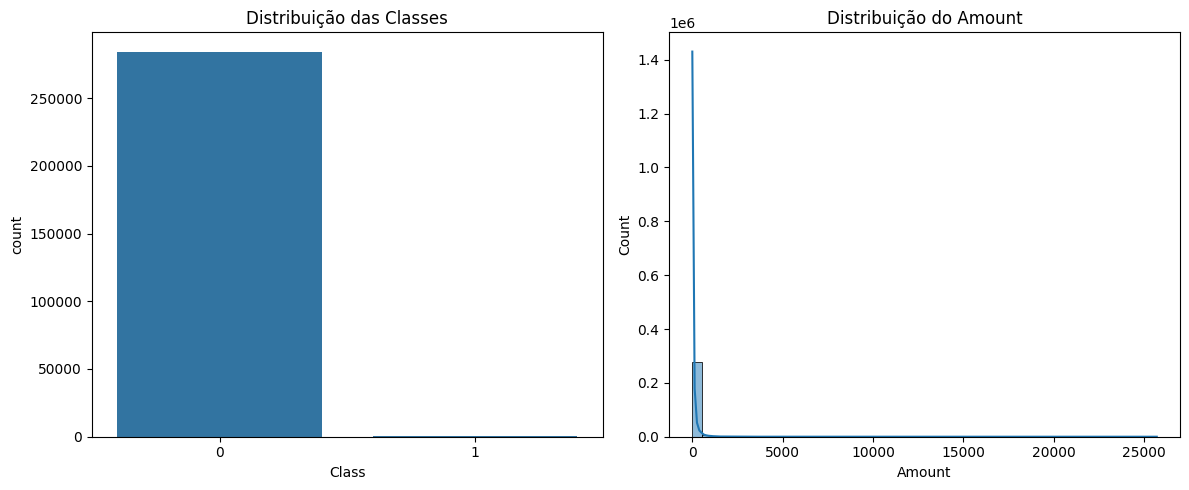

In [6]:
# Criar uma figura com 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribuição da variável target (Class)
sns.countplot(data=df, x='Class', ax=axes[0])
axes[0].set_title('Distribuição das Classes')

# Análise da distribuição da variável Amount
sns.histplot(df['Amount'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribuição do Amount')

plt.tight_layout()
plt.show()

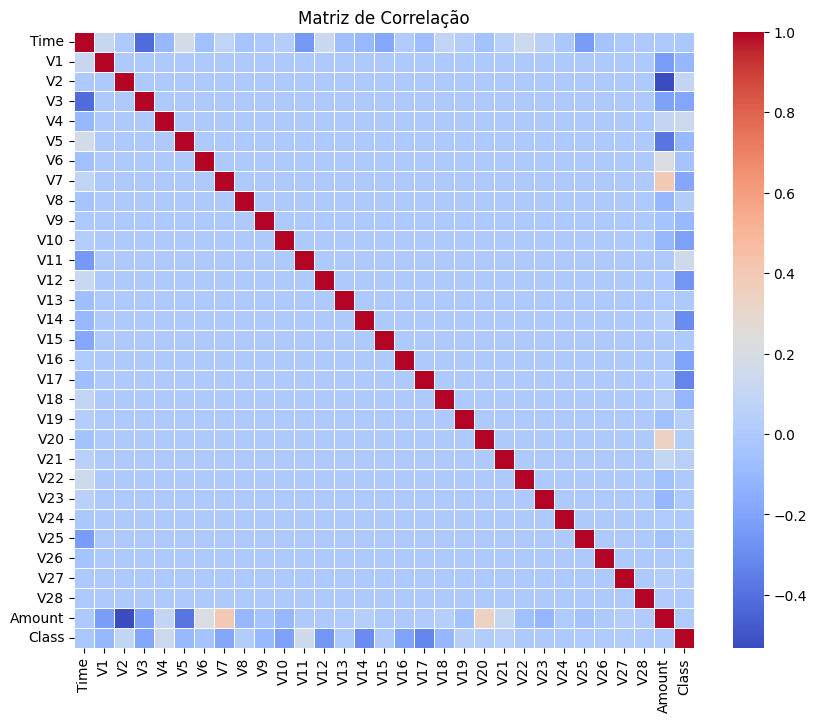

In [7]:
# Matriz de correlação
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [8]:
# Separando variáveis independentes e dependentes
X = df.drop('Class', axis=1)
y = df['Class']

# Análise de desbalanceamento das classes
print("\nDistribuição das Classes (Desbalanceadas):")
print(y.value_counts(normalize=True))
# Normalização da variável Amount
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])


Distribuição das Classes (Desbalanceadas):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [9]:
# Separação das variáveis independentes e dependentes
X = df.drop(columns=['Class'])
y = df['Class']
# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# Aplicação do SMOTE apenas nos dados de treino
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# Função para avaliar modelos
def avaliar_modelo(modelo, X_train, y_train, X_test, y_test):
    inicio = time.time()
    
    # Validação cruzada
    scores = cross_val_score(modelo, X_train, y_train, cv=5)
    media_scores = scores.mean()

    # Treinamento
    modelo.fit(X_train, y_train)

    # Predições e avaliação no conjunto de teste
    y_pred = modelo.predict(X_test)
    relatorio = classification_report(y_test, y_pred)
    matriz_confusao = confusion_matrix(y_test, y_pred)

    # Cálculo da AUC-ROC
    roc_auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])

    tempo_execucao = time.time() - inicio

    return {
        "scores": scores,
        "media_scores": media_scores,
        "relatorio": relatorio,
        "matriz_confusao": matriz_confusao,
        "roc_auc": roc_auc,
        "tempo_execucao": tempo_execucao
    }
# Modelos a serem avaliados
modelos = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Rede Neural": MLPClassifier(random_state=42, max_iter=300, early_stopping=True, validation_fraction=0.1, n_iter_no_change=15, verbose=True),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

In [11]:
# Avaliação dos modelos
resultados = {}
for nome, modelo in modelos.items():
    print(f"\nAvaliando modelo: {nome}")
    resultados[nome] = avaliar_modelo(modelo, X_train_res, y_train_res, X_test, y_test)

# Exibindo os resultados
for nome, resultado in resultados.items():
    print(f"\n=== {nome} ===")
    print("Scores de Validação Cruzada:", resultado['scores'])
    print("Média dos Scores:", resultado['media_scores'])
    print("Relatório de Classificação:\n", resultado['relatorio'])
    print("Matriz de Confusão:\n", resultado['matriz_confusao'])
    print("AUC-ROC:", resultado['roc_auc'])
    print("Tempo de Execução (s):", resultado['tempo_execucao'])


Avaliando modelo: Random Forest

Avaliando modelo: Rede Neural
Iteration 1, loss = 8.34710316
Validation score: 0.511525
Iteration 2, loss = 4.00285034
Validation score: 0.937633
Iteration 3, loss = 2.53327895
Validation score: 0.867793
Iteration 4, loss = 2.56098114
Validation score: 0.954999
Iteration 5, loss = 2.16090263
Validation score: 0.964200
Iteration 6, loss = 2.00554461
Validation score: 0.970921
Iteration 7, loss = 1.76535338
Validation score: 0.967623
Iteration 8, loss = 1.49440879
Validation score: 0.950603
Iteration 9, loss = 1.47528879
Validation score: 0.964954
Iteration 10, loss = 1.53995733
Validation score: 0.974155
Iteration 11, loss = 1.69634626
Validation score: 0.972208
Iteration 12, loss = 1.25790098
Validation score: 0.976291
Iteration 13, loss = 1.37143334
Validation score: 0.968723
Iteration 14, loss = 1.29937883
Validation score: 0.970041
Iteration 15, loss = 1.25330156
Validation score: 0.975286
Iteration 16, loss = 1.10228982
Validation score: 0.972554
I

In [12]:
# Salvando o modelo Random Forest como exemplo
import joblib
joblib.dump(modelos["Random Forest"], 'fraud_detection_model_rf.pkl')
print("\nModelo Random Forest salvo como 'fraud_detection_model_rf.pkl'")


Modelo Random Forest salvo como 'fraud_detection_model_rf.pkl'
